In [1]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/60/1b/9d3df1475d6c1548ad0278bc07fb396ef5f54418fb1f2acb4308feaa355e/torch-2.1.2-cp39-cp39-win_amd64.whl.metadata
  Using cached torch-2.1.2-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/81/54/84d42a0bee35edba99dee7b59a8d4970eccdd44b99fe728ed912106fc781/filelock-3.13.1-py3-none-any.whl.metadata
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3.2.1-py3-none-any.whl.metadata
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/70/25/fab23259a52ece5670dcb8452e1af34b89e6135ecc17cd4


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python.exe -m pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------------- ---------------------- 0.9/2.1 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 26.8 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


# Build model

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from data_transformation import dataset_loader
import torch.functional as F
import numpy as np

class PoseAdvisor(nn.Module):
    def __init__(self):
        super(PoseAdvisor, self).__init__()
        self.conv2d = nn.Conv2d(1, 32, (3, 3), padding=1)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.conv2d_1 = nn.Conv2d(32, 64, (3, 3), padding=1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(262144, 2056)
        self.linear2 = nn.Linear(2056, 256)
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(256, 39)

    def forward(self, x):
        # print("INPUT", x.shape)
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.pool(x)
        # print("LAYER 1", x.shape)
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.pool(x)
        # print("LAYER 2", x.shape)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu(x)
        # print("LAYER 3", x.shape)
        x = self.linear2(x)
        x = self.relu(x)
        # print("LAYER 4", x.shape)
        x = self.linear3(x)
        x = self.dropout(x)
        # print("LAYER 5", x.shape)

        return x

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model = PoseAdvisor().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
model

PoseAdvisor(
  (conv2d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2d_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=262144, out_features=2056, bias=True)
  (linear2): Linear(in_features=2056, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=256, out_features=39, bias=True)
)

In [3]:
device

device(type='cuda')

In [4]:
train_loader, test_loader = dataset_loader.dataload_create('images')

In [5]:
train_loader.dataset[1][1]

array([ 0.38659823,  0.34323916, -0.646097  ,  0.60950005,  0.40998498,
       -0.44809648,  0.35658485,  0.48338658, -0.29453683,  0.7997002 ,
        0.52322304, -0.49473137,  0.26518115,  0.61043155, -0.53400481,
        0.84262967,  0.72529489, -0.60592812,  0.36477888,  0.4342584 ,
       -0.86545229,  0.60763758,  0.69740027, -0.0502523 ,  0.45241639,
        0.72556525,  0.04961907,  0.78412586,  0.68041939, -0.62468386,
        0.19851077,  0.68360543, -0.31232497,  0.        ,  0.        ,
        0.        ,  0.59767306,  0.81355774, -0.38986233])

In [6]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        best_loss = float('inf')
        total_loss = 0
        number_of_iterations = 0
        for i, (x, y) in enumerate(train_loader):
            print('Training: ', i)
            print(type(x), x.shape, type(y), y.shape)
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            y_hat = y_hat.float()
            y = y.float()
            loss_val = loss(y_hat, y)
            total_loss += loss_val
            number_of_iterations += 1
            if loss_val < best_loss:
                best_loss = loss_val
            loss_val.backward()
            optimizer.step()
            print(f'Loss: {loss_val.item()}')
        average_loss = total_loss / number_of_iterations
        print(f'Epoch: {epoch+1}, Best loss: {best_loss.item()}, Average loss: {average_loss.item()}')
                
    torch.save(model.state_dict(), 'models/model3.pth')

In [7]:
train(10)

Epoch: 0
Training:  0
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 0.1445271372795105
Training:  1
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 22.906309127807617
Training:  2
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 3.1226258277893066
Training:  3
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 1.0908339023590088
Training:  4
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 0.7768325805664062
Training:  5
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 0.8411391973495483
Training:  6
<class 'torch.Tensor'> torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([1, 39])
Loss: 0.5074979662895203
Training:  7
<class 'torch.Tensor'> torch.Size([1, 1, 256, 2

KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), 'models/model3.pth')

In [9]:
model.load_state_dict(torch.load('models/model3.pth'))

<All keys matched successfully>

torch.Size([1, 1, 256, 256]) torch.float32 cpu tensor([[[[0.9529, 0.9569, 0.9804,  ..., 0.8941, 0.8902, 0.8902],
          [0.9569, 0.9647, 0.9843,  ..., 0.8980, 0.8980, 0.8941],
          [0.9647, 0.9725, 0.9882,  ..., 0.9020, 0.8980, 0.8941],
          ...,
          [0.3137, 0.3608, 0.3059,  ..., 0.2314, 0.2314, 0.2314],
          [0.3412, 0.3608, 0.3059,  ..., 0.2314, 0.2314, 0.2314],
          [0.3451, 0.3451, 0.2980,  ..., 0.2314, 0.2275, 0.2275]]]])
tensor([[[[0.9529, 0.9569, 0.9804,  ..., 0.8941, 0.8902, 0.8902],
          [0.9569, 0.9647, 0.9843,  ..., 0.8980, 0.8980, 0.8941],
          [0.9647, 0.9725, 0.9882,  ..., 0.9020, 0.8980, 0.8941],
          ...,
          [0.3137, 0.3608, 0.3059,  ..., 0.2314, 0.2314, 0.2314],
          [0.3412, 0.3608, 0.3059,  ..., 0.2314, 0.2314, 0.2314],
          [0.3451, 0.3451, 0.2980,  ..., 0.2314, 0.2275, 0.2275]]]])
torch.Size([1, 39]) torch.float32 cuda:0 tensor([[ 0.4267,  0.2885, -0.5418,  0.5242,  0.4184, -0.2094,  0.3010,  0.3917,
   

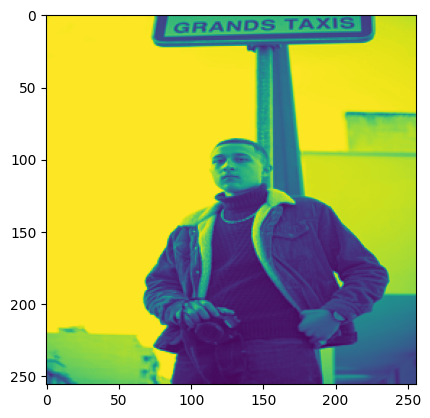

In [10]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

def preprocess(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    image = image.resize((256, 256))
    image = image.convert('L')
    image = np.array(image)
    image = image.reshape(1, 1, 256, 256)
    image = torch.from_numpy(image)
    image = image.float()
    image = image / 255.0
    print(image.shape, image.dtype, image.device, image)
    return image

img = preprocess('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_1a67208dd44d4d7dba3ab50e23caf8be.jpg')
def predict(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)
        return y_hat
    
plt.imshow(img[0][0])
print(img)
dots = predict(img)
print(dots.shape, dots.dtype, dots.device, dots)

In [11]:
dots = dots.reshape(13, 3)
dots = dots.cpu().numpy()
dots.shape, dots.dtype, dots

((13, 3),
 dtype('float32'),
 array([[ 0.42669868,  0.28846735, -0.54178977],
        [ 0.5242431 ,  0.41842148, -0.20936453],
        [ 0.30102202,  0.3916597 , -0.19759059],
        [ 0.38273248,  0.34505522, -0.256024  ],
        [ 0.14210583,  0.37819865, -0.2864744 ],
        [ 0.2880551 ,  0.2430502 , -0.27985182],
        [ 0.20650819,  0.3618334 , -0.46597618],
        [ 0.25937977,  0.30929172,  0.00492785],
        [ 0.2660327 ,  0.3205096 ,  0.01097246],
        [ 0.21260965,  0.3000492 , -0.10798784],
        [ 0.12703846,  0.21637042, -0.07370003],
        [ 0.19971536,  0.267817  , -0.0204851 ],
        [ 0.1337391 ,  0.2099054 ,  0.04945859]], dtype=float32))

In [12]:
import data_transformation.landmark_utils as landmark_utils

print(landmark_utils.generate_landmarks('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_1a67208dd44d4d7dba3ab50e23caf8be.jpg'))
landmark_utils.draw_landmarks('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_1a67208dd44d4d7dba3ab50e23caf8be.jpg', dots)

[[ 0.49161521  0.40611506 -0.42525479]
 [ 0.69299066  0.5373612  -0.182128  ]
 [ 0.40265715  0.56987423  0.04718148]
 [ 0.88218057  0.72266656 -0.24129882]
 [ 0.29292649  0.77233315 -0.03684198]
 [ 0.76384413  0.81386971 -0.43984079]
 [ 0.37306499  0.8063575  -0.45005682]
 [ 0.64430183  0.96240342 -0.07564531]
 [ 0.45825541  0.96962488  0.07781297]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


array([[ 0.42669868,  0.28846735, -0.54178977],
       [ 0.5242431 ,  0.41842148, -0.20936453],
       [ 0.30102202,  0.3916597 , -0.19759059],
       [ 0.38273248,  0.34505522, -0.256024  ],
       [ 0.14210583,  0.37819865, -0.2864744 ],
       [ 0.2880551 ,  0.2430502 , -0.27985182],
       [ 0.20650819,  0.3618334 , -0.46597618],
       [ 0.25937977,  0.30929172,  0.00492785],
       [ 0.2660327 ,  0.3205096 ,  0.01097246],
       [ 0.21260965,  0.3000492 , -0.10798784],
       [ 0.12703846,  0.21637042, -0.07370003],
       [ 0.19971536,  0.267817  , -0.0204851 ],
       [ 0.1337391 ,  0.2099054 ,  0.04945859]], dtype=float32)